# Import

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from prophet import Prophet # fbprophet is now just prophet
from sklearn.ensemble import VotingRegressor # StackingRegressor for stacking
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

/opt/miniconda3/envs/myenv_prophet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configure

In [2]:

warnings.filterwarnings('ignore')

# --- 0. Configuration & Helper Functions ---
TARGET_VARIABLE = 'net_interest_income_to_assets'
FEATURE_VARIABLES = ['gdp_qoq', 'deposit_ratio', 'loan_to_asset_ratio', 'log_total_assets', 'cpi_qoq', 'unemployment', 
                     'household_delinq', 'tbill_3m', 'tbill_10y', 'spread_10y_3m']
FORECAST_HORIZONS = list(range(1, 2))  # 1 to 8 quarters ahead
# Test split ratio
TEST_SPLIT_RATIO = 0.2
BANK_SAMPLE_SIZE = 100


# Load

In [3]:
data = pd.read_parquet('data.parquet')

# Drop observations after a certain date
# df = df[df.index <= '2011-12-31']

# Additional cleaning
nr_cells = data.shape[0] * data.shape[1]
nr_na = data.isna().sum().sum()
print(f"Number of NaNs in data: {nr_na} ({nr_na / nr_cells * 100:.2f}%)")
print(f"Removing NAs from the dataset...")
data = data.dropna(subset=FEATURE_VARIABLES + [TARGET_VARIABLE])



Number of NaNs in data: 13084695 (15.62%)
Removing NAs from the dataset...


In [4]:
X = data[FEATURE_VARIABLES].copy()
y = data[TARGET_VARIABLE].copy()

# Randomly select a sample of banks
bank_sample = X.index.get_level_values('id').unique()

bank_sample = np.random.choice(bank_sample, size=BANK_SAMPLE_SIZE, replace=False)
X = X[X.index.get_level_values('id').isin(bank_sample)]
y = y[y.index.get_level_values('id').isin(bank_sample)]

In [5]:
# Function that removes rows that belong to the variable that exhibits a very large absolute change from quarter to quarter.
def remove_large_changes(df, variable_name, threshold):
    """
    Remove rows where the absolute change in the specified variable exceeds the threshold.
    
    :param df: DataFrame containing the data
    :param variable_name: Name of the variable to check for large changes
    :param threshold: Threshold for absolute change
    :return: DataFrame with large changes removed
    """
    df = df.copy()
    # Calculate absolute change within each group identified by the 'id' level of the index
    # Fill NaN for the first entry in each group with 0, so it's not dropped by the threshold condition
    df['abs_change'] = df.groupby(level='id')[variable_name].diff().abs().fillna(0)
    
    # Keep rows where the change is within the threshold (or it's the first observation of a group)
    df_filtered = df[df['abs_change'] <= threshold]
    
    # Drop the temporary column
    df_filtered = df_filtered.drop(columns=['abs_change'])
    
    print(f"Removed {len(df) - len(df_filtered)} rows due to large changes in {variable_name}.")

    return df_filtered



X = remove_large_changes(X, "deposit_ratio", threshold=0.2) #<= threshold].drop(columns=['abs_change'])

# Require banks need to have deposit ratios above 0.6 at all times
def filter_banks_by_deposit_ratio(df, threshold=0.6):
    """
    Filter banks that have deposit ratios above a certain threshold at all times.
    
    :param df: DataFrame containing the data
    :param threshold: Minimum deposit ratio to keep a bank
    :return: DataFrame with banks filtered
    """
    valid_banks = df.groupby(level='id')['deposit_ratio'].min() >= threshold
    valid_bank_ids = valid_banks[valid_banks].index
    
    filtered_df = df[df.index.get_level_values('id').isin(valid_bank_ids)]
    
    print(f"Filtered out banks with deposit ratios below {threshold}. Remaining banks: {len(valid_bank_ids)}")
    
    return filtered_df
X = filter_banks_by_deposit_ratio(X, threshold=0.6)


Removed 13 rows due to large changes in deposit_ratio.
Filtered out banks with deposit ratios below 0.6. Remaining banks: 77


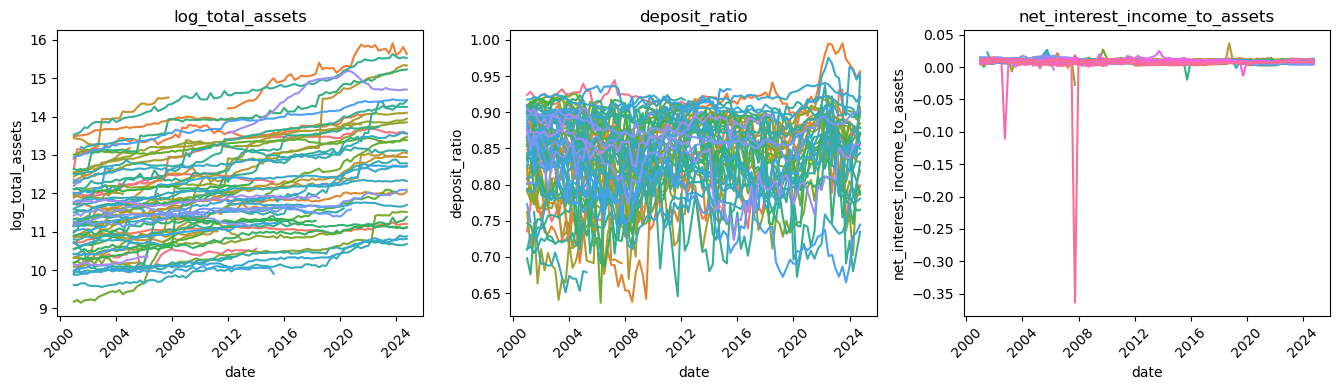

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

def plot_features_timeseries_flat(
    df: pd.DataFrame, 
    date_column: str = None, 
    id_column: str = None, 
    feature_columns: List[str] = None
):
    """
    Plots each specified feature of a DataFrame as a time series in a separate subplot,
    arranged in a 3-column grid. Each unique ID (from id_column) is plotted
    with a distinct color. The DataFrame is expected to be "flat", meaning
    date and ID are regular columns.

    Args:
        df (pd.DataFrame): DataFrame with date, id, and feature columns.
        date_column (str, optional): Name of the column containing date/time data.
                                     Defaults to 'Date'.
                                     This column should be sortable (e.g., datetime objects).
        id_column (str, optional): Name of the column containing ID data for hue.
                                   Defaults to 'id'.
        feature_columns (List[str], optional): List of column names for features to plot.
                                               Defaults to all columns not used as date_column or id_column.
    """
    # --- Input Validation ---
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")

    # --- Determine column names if not provided ---
    if date_column is None:
        date_column = 'date'
    if id_column is None:
        id_column = 'id'
    if feature_columns is None:
        feature_columns = [col for col in df.columns if col not in [date_column, id_column]]

    required_cols = [date_column, id_column] + feature_columns
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in DataFrame: {', '.join(missing_cols)}")


    if not feature_columns:
        print("No feature columns provided to plot.")
        return
    
    # Ensure date column is suitable for plotting (e.g., convert to datetime if it's string)
    # For simplicity, we'll assume it's already in a plottable format (datetime or numeric)
    # but in a real scenario, you might add:
    # if not pd.api.types.is_datetime64_any_dtype(df[date_column]) and \
    #    not pd.api.types.is_numeric_dtype(df[date_column]):
    #     try:
    #         df[date_column] = pd.to_datetime(df[date_column])
    #     except Exception as e:
    #         print(f"Warning: Could not convert date_column '{date_column}' to datetime: {e}")

    num_features = len(feature_columns)

    # --- Setup for plotting ---
    num_cols_grid = 3
    num_rows_grid = (num_features + num_cols_grid - 1) // num_cols_grid

    fig, axes = plt.subplots(
        num_rows_grid, num_cols_grid, 
        figsize=(5 * num_cols_grid, 4 * num_rows_grid), 
        sharex=True # Share x-axis for easier comparison
    )

    # Flatten axes array for easy iteration, handling single row/col cases
    axes_flat: np.ndarray[plt.Axes]
    if num_rows_grid == 1 and num_cols_grid == 1:
        axes_flat = np.array([axes])
    elif num_rows_grid == 1 or num_cols_grid == 1:
        axes_flat = axes if isinstance(axes, np.ndarray) else np.array([axes])
    else:
        axes_flat = axes.flatten()

    # --- Create plots ---
    legend_handles_map = {} # Using dict to ensure unique labels for the figure legend

    for i, feature_name in enumerate(feature_columns):
        ax = axes_flat[i]
        
        sns.lineplot(
            data=df,
            x=date_column,
            y=feature_name,
            hue=id_column,
            ax=ax,
            legend=True # Generate legend for this subplot to extract handles
        )
        
        # Collect unique handles and labels for the figure-level legend
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if label not in legend_handles_map: # Add if label is new
                legend_handles_map[label] = handle
        
        if ax.get_legend() is not None:
            ax.get_legend().remove() # Remove individual subplot legend

        ax.set_title(f'{feature_name}')
        ax.set_xlabel(date_column) # Use the provided date_column name
        ax.set_ylabel(feature_name)
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(num_features, len(axes_flat)):
        fig.delaxes(axes_flat[j])



    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
    plt.show()

all_data = pd.concat([X, y], axis=1)

plot_features_timeseries_flat(all_data.reset_index(), feature_columns=['log_total_assets', 'deposit_ratio', 'net_interest_income_to_assets'])

# Run regressions

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor # Keep if used
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet # Assuming Prophet is installed

# --- Configuration (Potentially move to a separate config file or section) ---
TARGET_VARIABLE = TARGET_VARIABLE 
FEATURE_VARIABLES = FEATURE_VARIABLES
FORECAST_HORIZONS = [1, 2, 4] # Example: 1-quarter, 2-quarters, 4-quarters ahead
TEST_SPLIT_RATIO = 0.2 # Proportion of data for the final hold-out test set
N_SPLITS_CV = 3 # Number of splits for TimeSeriesSplit cross-validation

# --- Helper Functions ---

def create_multistep_target(df: pd.DataFrame, variable_name: str, horizon: int) -> pd.DataFrame:
    """Creates a shifted target variable for multi-step forecasting."""
    df_copy = df.copy()
    target_col_name = f'{variable_name}_target_h{horizon}'
    df_copy[target_col_name] = df_copy[variable_name].shift(-horizon)
    df_copy.dropna(subset=[target_col_name], inplace=True) # Drop NaNs from target creation
    return df_copy

def prepare_data_for_horizon(df_full: pd.DataFrame, target_col_name: str, features_list: list, horizon: int, test_ratio: float):
    """
    Prepares features (X) and target (y) for a given horizon, splits into train/test, and scales features.
    """
    df_h = create_multistep_target(df_full, target_col_name, horizon)
    if df_h.empty:
        print(f"DataFrame is empty for horizon {horizon} after creating target. Skipping.")
        return None, None, None, None, None, None # Indicate failure

    y = df_h[f'{target_col_name}_target_h{horizon}']
    X = df_h[features_list]

    if X.empty or y.empty:
        print(f"X or y is empty for horizon {horizon} before splitting. Skipping.")
        return None, None, None, None, None, None

    # Split data into a final training set and a hold-out test set
    test_set_size = int(len(X) * test_ratio)
    if test_set_size < 1:
        print(f"Test set size too small for horizon {horizon} (needs at least 1). Skipping.")
        return None, None, None, None, None, None

    X_train, X_test = X[:-test_set_size], X[-test_set_size:]
    y_train, y_test = y[:-test_set_size], y[-test_set_size:]

    if X_train.empty or y_train.empty:
        print(f"Training set is empty after final split for horizon {horizon}. Skipping.")
        return None, None, None, None, None, None

    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled arrays back to DataFrames for easier use with some models/debugging
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return X_train_scaled_df, X_test_scaled_df, y_train, y_test, X_train, X_test # Return both scaled and original for Prophet

def get_models_and_param_grids():
    """Defines models and their hyperparameter grids for GridSearchCV."""
    class DummyRegressorMean: # Simplified Dummy Regressor
        def __init__(self): self.mean_ = None
        def fit(self, X, y): self.mean_ = y.mean()
        def predict(self, X): return np.full(len(X), self.mean_)

    models = {
        "DummyRegressor": DummyRegressorMean(),
        "LinearRegression": LinearRegression(),
        "Lasso": Lasso(random_state=42, max_iter=10000),
        "Ridge": Ridge(random_state=42, max_iter=10000),
        "ElasticNet": ElasticNet(random_state=42, max_iter=10000),
        "DecisionTree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1)
    }
    param_grids = {
        "Lasso": {'alpha': [0.001, 0.01, 0.1, 1, 10]},
        "Ridge": {'alpha': [0.001, 0.01, 0.1, 1, 10]},
        "ElasticNet": {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]},
        "DecisionTree": {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]},
        "XGBoost": {
            'n_estimators': [50, 100], # Reduced for brevity, expand for real use
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.7, 0.8]
        }
    }
    return models, param_grids

def train_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, param_grid=None, cv_splitter=None):
    """Trains a single model, tunes if param_grid is provided, and evaluates it."""
    best_model = model
    if param_grid and cv_splitter:
        print(f"    Tuning {model.__class__.__name__}...")
        search = GridSearchCV(model, param_grid, cv=cv_splitter, scoring='neg_mean_squared_error', n_jobs=-1)
        search.fit(X_train_scaled, y_train)
        best_model = search.best_estimator_
        # print(f"    Best params: {search.best_params_}")
    else:
        best_model.fit(X_train_scaled, y_train)

    predictions = best_model.predict(X_test_scaled)

    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    # MAPE can be problematic if y_test contains zeros
    y_test_no_zeros = y_test.replace(0, np.nan).dropna() # Avoid division by zero
    predictions_no_zeros = pd.Series(predictions, index=y_test.index)[y_test_no_zeros.index]
    mape = np.mean(np.abs((y_test_no_zeros - predictions_no_zeros) / y_test_no_zeros)) * 100 if not y_test_no_zeros.empty else np.nan


    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'model_object': best_model}

def train_evaluate_prophet(X_train_orig, y_train, X_test_orig, y_test):
    """Trains and evaluates a Prophet model."""
    print("    Training Prophet model...")
    prophet_train_df = X_train_orig.copy()
    prophet_train_df['ds'] = prophet_train_df.index
    prophet_train_df['y'] = y_train

    regressors_for_prophet = list(X_train_orig.columns)

    m_prophet = Prophet() # Add seasonality/changepoint args if needed
    for regressor in regressors_for_prophet:
        m_prophet.add_regressor(regressor)

    try:
        m_prophet.fit(prophet_train_df[['ds', 'y'] + regressors_for_prophet])

        future_df = X_test_orig.copy()
        future_df['ds'] = future_df.index

        if future_df.empty or not all(reg in future_df.columns for reg in regressors_for_prophet):
            print(f"    Prophet future_df is missing regressors or is empty. Skipping Prophet evaluation.")
            return None

        forecast_prophet = m_prophet.predict(future_df[['ds'] + regressors_for_prophet])
        # Align predictions with y_test (Prophet might return more rows than X_test if future_df is longer)
        predictions_prophet = forecast_prophet['yhat'].values[:len(y_test)]


        mae = mean_absolute_error(y_test, predictions_prophet)
        mse = mean_squared_error(y_test, predictions_prophet)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions_prophet)
        y_test_no_zeros = y_test.replace(0, np.nan).dropna()
        predictions_no_zeros = pd.Series(predictions_prophet, index=y_test.index)[y_test_no_zeros.index]
        mape = np.mean(np.abs((y_test_no_zeros - predictions_no_zeros) / y_test_no_zeros)) * 100 if not y_test_no_zeros.empty else np.nan

        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'model_object': m_prophet}
    except Exception as e:
        print(f"    Error during Prophet training/prediction: {e}")
        return None

def train_evaluate_ensemble(trained_models_dict, X_train_scaled, y_train, X_test_scaled, y_test):
    """Trains and evaluates a VotingRegressor ensemble model."""
    print("    Attempting to train Voting Regressor ensemble...")
    estimators = []
    # Example: Use XGBoost and Ridge if they were trained successfully
    if 'XGBoost' in trained_models_dict and trained_models_dict['XGBoost'].get('model_object'):
        estimators.append(('xgb', trained_models_dict['XGBoost']['model_object']))
    if 'Ridge' in trained_models_dict and trained_models_dict['Ridge'].get('model_object'):
        estimators.append(('ridge', trained_models_dict['Ridge']['model_object']))
    # Add more models as desired, ensuring they are already fitted instances

    if len(estimators) < 2:
        print("    Not enough base models for Voting Regressor. Skipping ensemble.")
        return None

    try:
        # Note: Estimators passed to VotingRegressor should ideally be pre-fitted clones
        # if they come from GridSearchCV. If not, VotingRegressor will fit them.
        # The model_objects stored are already the best_estimators (fitted).
        voting_reg = VotingRegressor(estimators=estimators, n_jobs=-1)
        voting_reg.fit(X_train_scaled, y_train) # Fit the ensemble
        predictions = voting_reg.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
        y_test_no_zeros = y_test.replace(0, np.nan).dropna()
        predictions_no_zeros = pd.Series(predictions, index=y_test.index)[y_test_no_zeros.index]
        mape = np.mean(np.abs((y_test_no_zeros - predictions_no_zeros) / y_test_no_zeros)) * 100 if not y_test_no_zeros.empty else np.nan
        
        print("    Voting Regressor trained successfully.")
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'model_object': voting_reg}
    except Exception as e:
        print(f"    Error training Voting Regressor: {e}")
        return None

def aggregate_and_display_results(results_store: dict):
    """Aggregates results from all horizons and models, prints a summary, and plots RMSE."""
    print("\n\n--- Final Model Performance Summary ---")
    summary_entries = []
    for horizon, models_results in results_store.items():
        for model_name, metrics in models_results.items():
            if isinstance(metrics, dict): # Ensure 'metrics' is a dictionary
                summary_entries.append({
                    'Horizon': horizon,
                    'Model': model_name,
                    'MAE': metrics.get('MAE', np.nan),
                    'RMSE': metrics.get('RMSE', np.nan),
                    'R2': metrics.get('R2', np.nan),
                    'MAPE': metrics.get('MAPE', np.nan)
                })

    if not summary_entries:
        print("No results to display. Check for errors during model training or evaluation.")
        return

    summary_df = pd.DataFrame(summary_entries)
    summary_df = summary_df.sort_values(by=['Horizon', 'RMSE'])
    print(summary_df.to_string())

    # Plot RMSE by Horizon for each model
    plt.figure(figsize=(14, 8))
    for model_name in summary_df['Model'].unique():
        model_data = summary_df[summary_df['Model'] == model_name]
        plt.plot(model_data['Horizon'], model_data['RMSE'], marker='o', linestyle='-', label=model_name)
    
    plt.xlabel("Forecast Horizon (Quarters)")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.title("Model RMSE vs. Forecast Horizon", fontsize=16)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(FORECAST_HORIZONS) # Ensure ticks match the tested horizons
    plt.tight_layout() # Adjust layout to make room for legend
    plt.show()




results_store = {}  # Store results for each horizon and model
models_config, param_grids_config = get_models_and_param_grids()

# --- Iterate through each forecast horizon ---
for horizon in FORECAST_HORIZONS:
    print(f"\n--- Processing Horizon: {horizon}-quarter(s) ahead ---")
    results_store[horizon] = {}

    # Prepare data for the current horizon
    data_prep_results = prepare_data_for_horizon(
        all_data, TARGET_VARIABLE, FEATURE_VARIABLES, horizon, TEST_SPLIT_RATIO
    )
    if data_prep_results[0] is None: # Check if data preparation failed
        continue # Skip to the next horizon
    
    X_train_scaled_df, X_test_scaled_df, y_train, y_test, X_train_orig, X_test_orig = data_prep_results

    # TimeSeriesSplit for cross-validation
    current_n_splits_cv = N_SPLITS_CV
    if len(X_train_scaled_df) < current_n_splits_cv * 2: # Need at least 2 samples per split for train/test
        print(f"  Not enough samples in training set ({len(X_train_scaled_df)}) for {current_n_splits_cv} splits. Trying to reduce.")
        if len(X_train_scaled_df) >= 4: # Minimum for 2 splits
            current_n_splits_cv = 2
            print(f"  Reduced CV splits to {current_n_splits_cv}.")
        else:
            print(f"  Skipping horizon {horizon} due to insufficient training data for CV.")
            continue
    tscv_splitter = TimeSeriesSplit(n_splits=current_n_splits_cv)

    # --- Train and Evaluate Standard Models ---
    for name, model_instance in models_config.items():
        print(f"  Training {name} for horizon {horizon}...")
        model_results = train_evaluate_model(
            model_instance,
            X_train_scaled_df, y_train,
            X_test_scaled_df, y_test,
            param_grid=param_grids_config.get(name),
            cv_splitter=tscv_splitter if param_grids_config.get(name) else None
        )
        if model_results:
            results_store[horizon][name] = model_results
            print(f"    {name} - RMSE: {model_results['RMSE']:.4f}, R2: {model_results['R2']:.4f}")


    # --- Train and Evaluate Prophet Model ---
    prophet_results = train_evaluate_prophet(X_train_orig, y_train, X_test_orig, y_test)
    if prophet_results:
        results_store[horizon]['Prophet'] = prophet_results
        print(f"    Prophet - RMSE: {prophet_results['RMSE']:.4f}, R2: {prophet_results['R2']:.4f}")
        
    # --- (Optional) Train and Evaluate Ensemble Model ---
    if results_store[horizon]: # Proceed only if there are base models trained for this horizon
        ensemble_results = train_evaluate_ensemble(results_store[horizon], X_train_scaled_df, y_train, X_test_scaled_df, y_test)
        if ensemble_results:
            results_store[horizon]['VotingEnsemble'] = ensemble_results
            print(f"    VotingEnsemble - RMSE: {ensemble_results['RMSE']:.4f}, R2: {ensemble_results['R2']:.4f}")

    # --- Aggregate and Display All Results ---
    aggregate_and_display_results(results_store)

    print("\n--- Notes ---")
    print("1. Ensure 'TARGET_VARIABLE' and 'FEATURE_VARIABLES' are correctly defined.")
    print("2. Replace dummy data loading with your actual data pipeline.")
    print("3. Adjust 'FORECAST_HORIZONS', 'TEST_SPLIT_RATIO', and 'N_SPLITS_CV' as needed.")
    print("4. Prophet regressors: This setup assumes all features in 'FEATURE_VARIABLES' are lagged and known at prediction time.")
    print("   If regressors themselves need forecasting, that's an additional layer of complexity.")



--- Processing Horizon: 1-quarter(s) ahead ---
  Training DummyRegressor for horizon 1...
    DummyRegressor - RMSE: 0.0120, R2: -0.0078
  Training LinearRegression for horizon 1...


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Tests

## Plot for each model errors vs. predicted values

In [ ]:
import math

from pyparsing import line

# Plot for each model predictions vs actuals in 3-column facets

num_models = sum(len(models_results) for models_results in results_store.values())
num_cols = 3
num_rows = math.ceil(num_models / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

plot_index = 0

# Select from results_store the three models that performed best in the test set in terms of RMSE for horizon 1
results_store_filtered = results_store.copy()
# Filter results_store for horizon 1
results_store_filtered = {horizon: models_results for horizon, models_results in results_store.items() if horizon == 1}


for horizon, models_results in results_store_filtered.items():
    #if horizon > 1: break
    for model_name, metrics in models_results.items():
        
        if 'model_object' in metrics and model_name != 'Prophet' and model_name != "Voting Ensemble":
            print(model_name)
            X_data_train = models_results[model_name]['X_train_scaled']
            y_data_train = models_results[model_name]['y_train']

            X_data_test = models_results[model_name]['X_test_scaled']
            y_data_test = models_results[model_name]['y_test']

            mae = metrics['MAE']
            rmse = metrics['RMSE']
            mape = metrics['MAPE']

            ax = axes[plot_index]
            model = metrics['model_object']
            if hasattr(model, 'predict'):
                # Get predictions
                predictions_train = model.predict(X_data_train)
                predictions_test = model.predict(X_data_test)

                # Plotting
                ax.plot(y_data_train.index, y_data_train.values, label='Actual', color='blue')
                ax.plot(y_data_test.index, y_data_test.values, label='Actual', color='blue', linestyle='dashed')
    
                ax.plot(y_data_train.index, predictions_train, label=f'Predicted ({model_name})', color='orange')
                ax.plot(y_data_test.index, predictions_test, label=f'Predicted ({model_name})', color='orange', linestyle='dashed')
                ax.set_title(f'{model_name} {horizon}-Quarter Ahead (MAPE: {mape:.4f})', fontsize=10)
                ax.set_xlabel('Date', fontsize=8)
                ax.set_ylabel(TARGET_VARIABLE, fontsize=8)
                ax.tick_params(axis='x', rotation=45, labelsize=6)
                ax.tick_params(axis='y', labelsize=6)
                ax.legend(fontsize=7)
                ax.grid(True)

                plot_index += 1

# Remove empty subplots if the number of models is not a multiple of num_cols
if plot_index < len(axes):
    for i in range(plot_index, len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

In [ ]:
debug_df_features[1]['X_train']['net_operating_income']

date
1991-04-01     3495.03511
1991-07-01     2952.09662
1991-10-01     1440.17283
1992-01-01     7640.16761
1992-04-01     8323.48921
                 ...     
2006-07-01    37400.82699
2006-10-01    32896.05707
2007-01-01    35227.38525
2007-04-01    36704.06241
2007-07-01    29668.29543
Name: net_operating_income, Length: 66, dtype: float64

In [ ]:
# Check target and feature variables for different forecasting horizons
check_data_horizons = (pd
                       .merge(debug_df_target[1]['y_train'], 
                              debug_df_features[1]['X_train'][TARGET_VARIABLE], how="left", on="date")
                       .merge(debug_df_target[2]['y_train'], how="left", on="date")
                       .merge(debug_df_features[2]['X_train'][TARGET_VARIABLE], how="left", on="date"))

check_data_horizons

,net_operating_income_target_h1,net_operating_income_x,net_operating_income_target_h2,net_operating_income_y
date,,,,
1991-04-01,2952.09662,3495.03511,1440.17283,3495.03511
1991-07-01,1440.17283,2952.09662,7640.16761,2952.09662
1991-10-01,7640.16761,1440.17283,8323.48921,1440.17283
1992-01-01,8323.48921,7640.16761,8388.03707,7640.16761
1992-04-01,8388.03707,8323.48921,7920.98610,8323.48921
...,...,...,...,...
2006-07-01,32896.05707,37400.82699,35227.38525,37400.82699
2006-10-01,35227.38525,32896.05707,36704.06241,32896.05707
2007-01-01,36704.06241,35227.38525,29668.29543,35227.38525
